# consema on OASIS data

- Author: Luca Mossina. IRT Saint Exupéry, Toulouse, France

**Scope**: test the full pipeline for Conformal Prediction on OASIS

- data: OASIS. Downloaded to `/tmp/universeg_oasis` by the universeg code (git-cloned via [Makefile](../Makefile))
- predictor: Universeg
- nonconformity score: thresholding, n. of dilations, radius of structuring element

In [ ]:
from dotenv import load_dotenv
import torch
import matplotlib.pyplot as plt
from consema.conformal import Conformalizer

from universeg import universeg  # installed via Makefile

model = universeg(pretrained=True)

GPUNAME = "cuda:0"
device_str = GPUNAME if torch.cuda.is_available() else "cpu"
device = torch.device(device_str)

_ = model.to(device)

RANDOM_SEED = 1

## Setup data, predictors and predictions

In [ ]:
import os
import itertools
from benchmarkerie.datasets import ExtendedOASISDataset
from benchmarkerie.datasets import make_universeg_predictions

# from typing import Literal
import numpy as np

In [ ]:
def setupOASIS(n_support_samples, label, random_seed, device="cpu"):
    data_support = ExtendedOASISDataset(
        split="support", label=label, random_seed=random_seed
    )
    data_calib = ExtendedOASISDataset(
        split="calibration", label=label, random_seed=random_seed
    )
    data_test = ExtendedOASISDataset(split="test", label=label, random_seed=random_seed)

    print(f"{len(data_support) = }")
    print(f"{len(data_calib) = }")
    print(f"{len(data_test) = }")

    assert n_support_samples <= len(data_support), "Not enough support samples"

    support_images, support_labels = zip(
        *itertools.islice(data_support, n_support_samples)
    )
    support_images = torch.stack(support_images).to(device)
    support_labels = torch.stack(support_labels).to(device)

    return data_support, data_calib, data_test, support_images, support_labels


data_support, data_calib, data_test, support_images, support_labels = setupOASIS(
    24,
    0,
    random_seed=RANDOM_SEED,
    device=device_str,
)

len(data_support) = 289
len(data_calib) = 50
len(data_test) = 75


In [ ]:
# n_support_samples = 48  # high performance predictor
# n_support_samples = 12  # lower performance predictor
n_support_samples = 24  # middle performance predictor

# LABEL = 0  # background: used in the paper (not the most interesting label...)
LABEL = 1  # left-hand side of brain image (todo: look up the actual label name)
# LABEL = 10

data_support, data_calib, data_test, support_images, support_labels = setupOASIS(
    n_support_samples,
    LABEL,
    random_seed=RANDOM_SEED,
    device=device_str,
)


LOAD_PREDS = False
SAVE_PREDS = False

if SAVE_PREDS:
    load_dotenv()
    PREDS_DIR = os.getenv("EXPERIMENTS_DIR", "experiments")
else:
    PREDS_DIR = None


if LOAD_PREDS:
    load_dotenv()
    PREDS_DIR = os.getenv("EXPERIMENTS_DIR", "experiments")

    calib_preds = np.load(f"{PREDS_DIR}/calib_nsup_{n_support_samples}.npz")

    calib_images = calib_preds["images"]
    calib_gt_masks = calib_preds["gt_masks"]
    calib_predictions = calib_preds["preds"]

    print("Calibration predictions loaded.")
    print("Test predictions loaded.")

# # Save predictions for calibration and test datasets in single files
calib_images, calib_gt_masks, calib_predictions = make_universeg_predictions(
    dataset=data_calib,
    dataset_name=f"calib_nsup_{n_support_samples}",
    device_str=device_str,
    support_images=support_images,
    support_labels=support_labels,
    universeg_model=model,
    save_to=PREDS_DIR,
)

len(data_support) = 289
len(data_calib) = 50
len(data_test) = 75


In [ ]:
import numpy as np

DO_LOAD = False

if DO_LOAD:
    # Load predictions for calibration and test datasets
    calib_preds = np.load(f"{PREDS_DIR}/calib_nsup_{n_support_samples}.npz")

    calib_images = calib_preds["images"]
    calib_gt_masks = calib_preds["gt_masks"]
    calib_predictions = calib_preds["preds"]

    print("Calibration predictions loaded.")
    print("Test predictions loaded.")

### Visualize False Negatives: we want to control their quantity

Via conformal prediction, we control how many false negative we will have, on average, in our test inferences (e.g. when deployed in production)

In [ ]:
from consema.plots import visualize_false_negatives

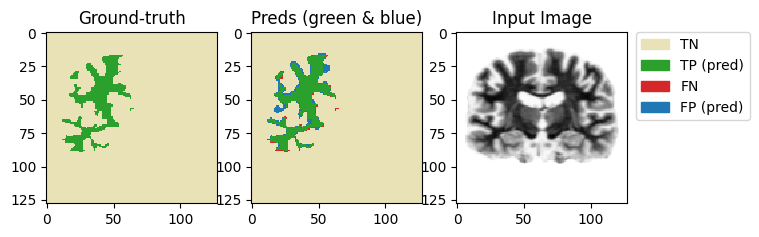

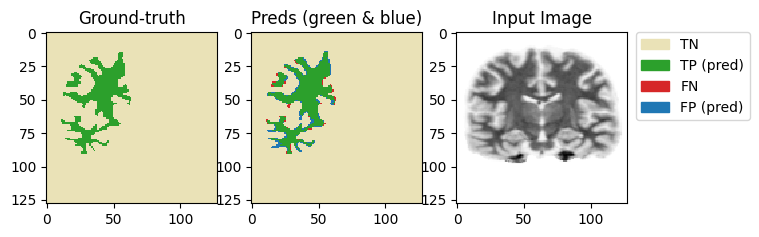

In [ ]:
for it, (image, prediction, gt) in enumerate(
    zip(calib_images, calib_predictions, calib_gt_masks)
):
    if it >= 2:
        break
    visualize_false_negatives(image[0], gt[0], prediction[0] > 0.5)

In the figure above, the **red points** are false negatives, that is, points that belong to the ground-truth masks but were not predicted by the algorithm.

Using conformal prediction, we want to "extend" the prediction area (in green) with a conformal margin so that we limit our prediction errors, that is, we reduce the number of false negative with high probability at a significance level chosen by the user.

The price to pay are more false positives: in this case, we can imagine that false positives push the users to be more conservative and they are "safe" errors.

If there are too many false positives, then the prediction becomes operationally useless; this tradeoff is controlled by the user and their predictive model: worse models will have more false negatives, hence larger conformal margins. 

In [ ]:
from consema.morphology import (
    dilation_metrics,
)
from consema.conformal import thresholding_score
from consema.plots import plot_margin_and_recovered, visualize_false_negatives

In [ ]:
idx_ = 10
bintruth = calib_gt_masks[idx_] > 0.5
binpred = calib_predictions[idx_] > 0.5
softpred = calib_predictions[idx_]

cov_threshold = 0.99

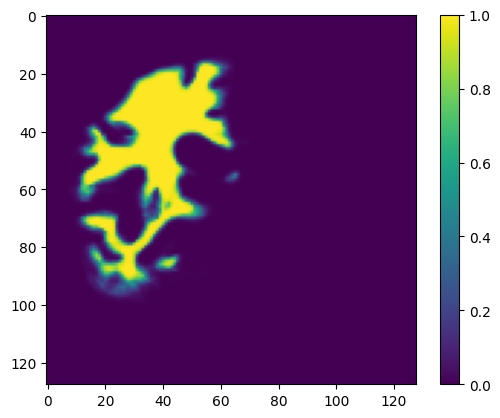

In [ ]:
plt.imshow(softpred[0])
plt.colorbar()
plt.show()

### Thresholding nonconformity score

Sources:
- LAC (Least Ambiguous Set-Valued Classifiers), [Sadinle et al. (2019)](https://arxiv.org/abs/1609.00451)
- CRC (Conformal Risk Control), [Angelopoulos et al. (2022)](https://arxiv.org/abs/2208.02814)

**Thresholding the softmax** or sigmoid scores for **classification** follows from the theory developed in Sadinle et al. (2019), where they work with generic probability distribution, not specifically with neural networks. In this case, the probability estimates (e.g. softmax scores) are known to be not calibrated, and some properties (e.g. optimal size of prediction sets) do not necessarily hold. 

As for **binary image segmentation** with an underlying pixel-wise classifier, this was introduced as an application of their CRC algorithm by Angelopoulos et al. (2022): they do not explicitly mention nonconformity scores, although it follows immediately from their definition of risk and computation of $\hat{\lambda}$, for the case of binary (conformal) losses.

In [ ]:
nc_threshold, dilated_threshold_mask = thresholding_score(
    gt_mask_=bintruth,
    soft_pred_mask_=softpred,
    # se_params_=se_params,
    coverage_threshold=cov_threshold,
    return_dilated_mask=True,
)

print(f"{nc_threshold = :.9f}")
metrics = dilation_metrics(dilated_threshold_mask[0], binpred[0])
print(f" --- THRESH: n. added px = {metrics[0]}, stretch = {metrics[1]}")

coverage_tensor = np.multiply(dilated_threshold_mask, bintruth)
coverage_ratio = np.sum(coverage_tensor) / np.count_nonzero(bintruth)
print(f"{coverage_ratio = :.9f}")

nc_threshold = 0.744405076
 --- THRESH: n. added px = 261, stretch = 1.1717105263157894
coverage_ratio = 0.990453461


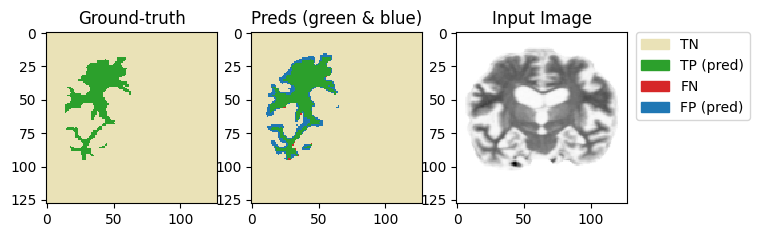

In [ ]:
visualize_false_negatives(calib_images[idx_][0], bintruth[0], dilated_threshold_mask[0])

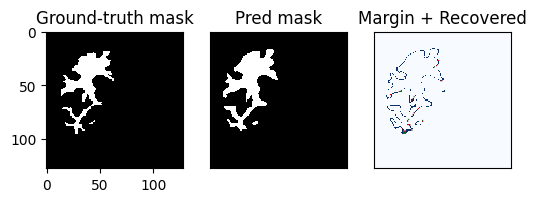

In [ ]:
plot_margin_and_recovered(
    binpred[0],
    bintruth[0],
    dilated_threshold_mask[0],
    plot_hard_margin=False,
    figsize=(6, 3),
)

### Morphological prediction sets: dilation

This is part of the original contribution of the paper: building statistically valid prediction sets under minimal information.
- No softmax/sigmoid scores necessary
- usable on blackbox predictor, e.g. hidden behind API, MLaaS, etc.
- only need a small dataset of labeled, production-like data to measure uncertainty
- literature available: mathematical morphology for computer vision (without deep learning)

I introduce two cases:
- (3x3) structuring element, either square or cross: iteratively dilate the mask as dilated at previous iterations until $\tau \times 100 \%$ of the ground-truth pixels are recovered. Applying several dilations (or other) is also known as **depth** of the dilation. This will constitue the nonconformity score, the higher the worse the prediction was.
- variable-size disk: as above, but only apply one dilation to the predicted mask, with the radius of the disk increasing at each iteration

In [ ]:
from consema.morphology import (
    dilation_score_variable_disk,
    dilation_score_fixed_disk,
)

from consema.morphology import (
    # to compute as sequence of dilations of fixed structuring element
    operator_dilation_sequential,
    # to compute _one_ dilation with a discretized disk of given radius (in pixels)
    operator_dilation_disk_radius,
)


se_params = dict(strict_radius=True)  # [3 X 3] cross
# se_params = dict(strict_radius=False)  # [3 X 3] square

#### Iterative dilations

Nonconcormity score = depth, or number of repeated dilations.
- Using fixed-size structuring element

nc_fixed = 1
 ---  FIXED: n. added px = 374, stretch = 1.2460526315789473


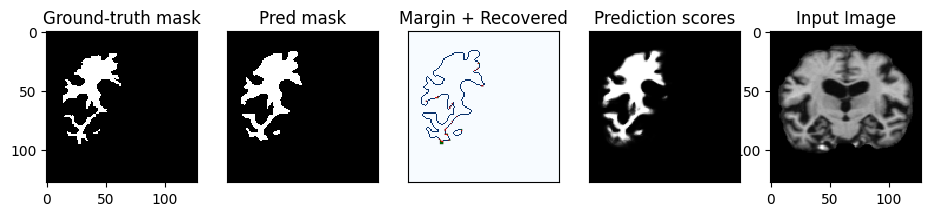

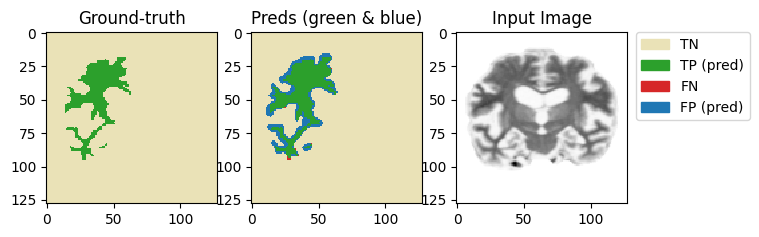

In [ ]:
## 1. Fixed disk
nc_fixed = dilation_score_fixed_disk(
    gt_mask_=bintruth[0],
    pred_mask_=binpred[0],
    se_params_=se_params,
    coverage_threshold=cov_threshold,
)
dilated_mask_fixed = operator_dilation_sequential(
    input_mask=binpred[0],
    operator_parameter=nc_fixed,
    se_params_=se_params,
)

print(f"{nc_fixed = }")
metrics = dilation_metrics(dilated_mask_fixed, binpred[0])
print(f" ---  FIXED: n. added px = {metrics[0]}, stretch = {metrics[1]}")
plot_margin_and_recovered(
    binpred[0],
    bintruth[0],
    dilated_mask_fixed,
    input_image=calib_images[idx_][0],
    softprediction=softpred[0],
)
visualize_false_negatives(calib_images[idx_][0], bintruth[0], dilated_mask_fixed)

#### Variable-size disk as structuring element

Instead of repeating dilations incrementally, on can obtain a similar results modifying the radius of the structuring element used for dilations.

Computationally, it should be worse than fixed-size for big radii: a naive implementation requires a number a computations that grows quadratically with the size (H x W) of the structuring element.

For binary dilations (our case), one can use a convolution followed by a max: this can be a good option if working directly with torch and tensors; with large images, we could expect comp. gains via gpus.

nc_variable = 1


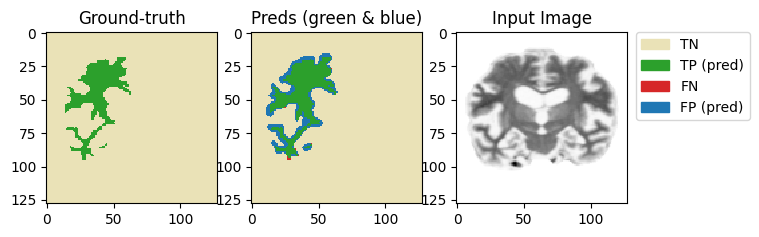

 ---  VARIA: n. added px = 374, stretch = 1.2460526315789473


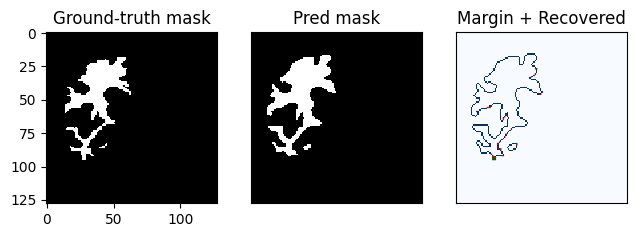

In [ ]:
## 2. Variable disk
nc_variable = dilation_score_variable_disk(
    gt_mask_=bintruth[0],
    pred_mask_=binpred[0],
    se_params_=se_params,
    coverage_threshold=cov_threshold,
)
dilated_mask_variable = operator_dilation_disk_radius(
    input_mask=binpred[0],
    operator_parameter=nc_variable,
    se_params_=se_params,
)
print(f"{nc_variable = }")
visualize_false_negatives(calib_images[idx_][0], bintruth[0], dilated_mask_variable)

metrics = dilation_metrics(dilated_mask_variable, binpred[0])
print(f" ---  VARIA: n. added px = {metrics[0]}, stretch = {metrics[1]}")
plot_margin_and_recovered(binpred[0], bintruth[0], dilated_mask_variable)

---

## Conformal loop: compute scores and quantiles

### Visualize margin: use a gradient to show successive dilations and recovered pixels

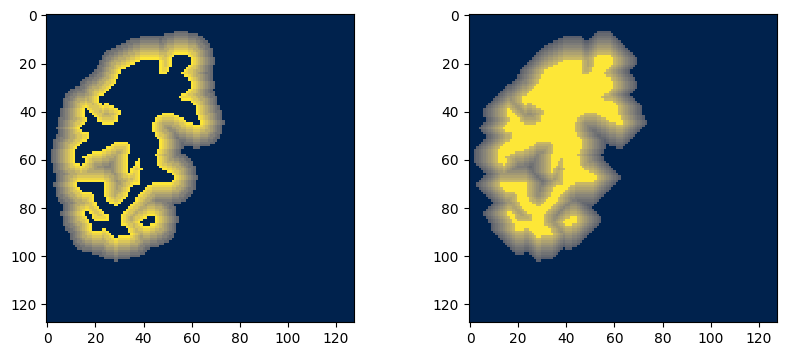

In [ ]:
from consema.plots import margin_gradient_visu

margin_var = margin_gradient_visu(
    binpred[0], "variable_disk", 10, None, False, se_params
)
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].imshow(margin_var, cmap="cividis", interpolation="none")
margin_fixed = margin_gradient_visu(binpred[0], "fixed_disk", 10, None, True, se_params)
ax[1].imshow(margin_fixed, cmap="cividis", interpolation="none")
plt.show()

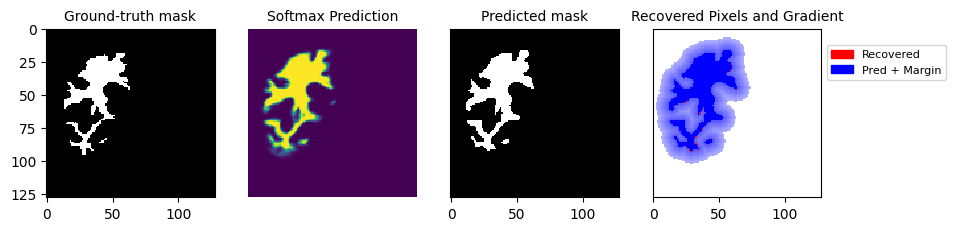

In [ ]:
from matplotlib.patches import Patch
from consema.conformal import recovered_pixels_bin_array

_grad = margin_gradient_visu(binpred[0], "variable_disk", 10, 20, True, se_params)

# Assuming _grad is your H x W array
H, W = _grad.shape
rgba_image = np.zeros((H, W, 4), dtype=np.uint8)  # Create an RGBA array

# Normalize the gradient to the range [0, 1]
normalized_grad = _grad / np.max(_grad)

# Set all pixels that are non-zero in the recovered mask to red with full opacity
recovered = recovered_pixels_bin_array(bintruth[0], binpred[0], dilated_mask_variable)

# Define blending factor and colors
alpha_blend = 0.7  # Controls red intensity (0 = no red, 1 = fully red)

# Assign colors: white for zeros, blue for non-zero entries
nonmargin_indices = np.where(_grad > 0)
rgba_image[..., 0] = (1 - normalized_grad) * 255  # Red channel
rgba_image[..., 1] = (1 - normalized_grad) * 255  # Green channel
rgba_image[..., 2] = 255  # Blue channel
rgba_image[..., 3] = (normalized_grad * 255).astype(
    np.uint8
)  # Alpha channel (transparency)

# Blend red for recovered pixels
recovered_indices = np.where(recovered == 1)
rgba_image[recovered_indices] = (
    alpha_blend * np.array([255, 0, 0, 255])  # Red with full opacity
    + (1 - alpha_blend) * rgba_image[recovered_indices]
).astype(np.uint8)

# Visualize the RGBA image
fig, ax = plt.subplots(1, 4, figsize=(10, 5))

# Plot ground truth mask on the left
ax[0].imshow(bintruth[0], cmap="gray", interpolation="none")
ax[0].set_title("Ground-truth mask", fontsize=10)
# ax[0].axis("off")

# Plot softmax prediction
ax[1].imshow(softpred[0], cmap="viridis", interpolation="none")
ax[1].set_title("Softmax Prediction", fontsize=10)
ax[1].axis("off")

# plot hard predicted mask
ax[2].imshow(binpred[0], cmap="gray", interpolation="none")
# ax[2].imshow(binpred[0], cmap="Greens", interpolation="none")
ax[2].set_title("Predicted mask", fontsize=10)
ax[2].get_yaxis().set_visible(False)

# Plot RGBA image on the right
ax[3].imshow(rgba_image, interpolation="none")
ax[3].set_title("Recovered Pixels and Gradient", fontsize=10)
ax[3].get_yaxis().set_visible(False)

legend_elements = [
    Patch(facecolor="red", edgecolor="red", label="Recovered"),
    Patch(facecolor="blue", edgecolor="blue", label="Pred + Margin"),
]

ax[3].legend(
    handles=legend_elements, fontsize=8, loc="center left", bbox_to_anchor=(1, 0.8)
)
plt.show()

### Setup conformalizer

In [ ]:
from benchmarkerie.models import UniversegInferenceWrap

inferencer = UniversegInferenceWrap(
    model=model,
    support_images=support_images,
    support_labels=support_labels,
    device=device,
    return_numpy=True,
)

### Setup conformal parameters
- `covratio` $\in (0,1)$ (coverage ratio): how many ground-truth pixels must be covered in each image to be considered a success
- `alpha` $ \in (0,1)$ (nominal risk): on average, how many inferences can be wrong (but we don't say by how much)

During conformalization, the nonconformity scores tell
- how many dilations, or 
- how big the structuring element (e.g. disk), or
- which threshold $\in (0,1)$

was necessary to achieve the specified `covratio`. If `covratio = 1`, then 100% of the ground-truth pixels must be captured.

In [ ]:
# covratio = 0.99999
# covratio = 0.999
covratio = 0.99
# covratio = 1.0

# alpha = 0.90
# alpha = 0.50
alpha = 0.10
# alpha = 0.80  # BAD just for testing

score_funcs = ["fixed_disk", "variable_disk", "thresholding"]
# chosen_nc_score = score_funcs[0]
chosen_nc_score = score_funcs[1]
# chosen_nc_score = score_funcs[2]

#### Compute nonconformity scores

In [ ]:
print(f" --- n calibration points: {len(data_calib)}")

cpred = Conformalizer(
    inferencer=inferencer,
    nonconformity_function_name=chosen_nc_score,
    structuring_element_params=se_params,
)

confo_resu = cpred.compute_nonconformity_scores(data_calib, covratio)

 --- n calibration points: 50


/home/luca.mossina/projects/vision/consema/src/benchmarkerie/models.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, label = torch.tensor(image).to(self.device), torch.tensor(label).to(


#### Compute conformalizing empirical quantile

 --- Required coverage ratio = 0.99
 --- Probability of succes on test = 0.9
 --- Chosen nonconformity score: variable_disk


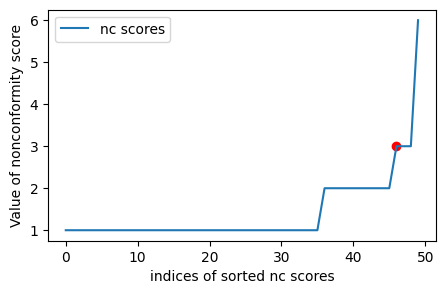

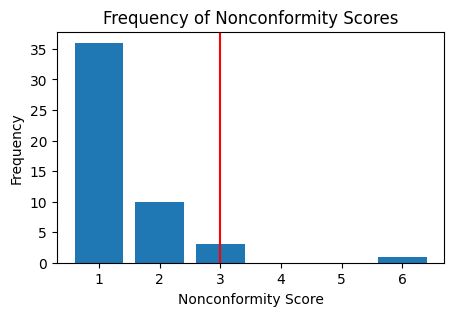

In [ ]:
print(f" --- Required coverage ratio = {covratio}")
print(f" --- Probability of succes on test = {1 - alpha}")
print(f" --- Chosen nonconformity score: {chosen_nc_score}")
# cpred.plot_nc_scores(confo_resu["nonconformity"], alpha)
cpred.plot_nc_scores(alpha_risk=alpha)
cpred.plot_nc_scores_frequency(alpha=alpha)

#### Metrics of conformal prediction sets on test data

In [ ]:
print(f" --- Required coverage ratio = {covratio}")
print(f" --- Probability of succes on test >= {1 - alpha}")
print()
test_preds = cpred.test_inferences(data_test)
test_results = cpred.test_conformalization(test_preds, alpha, covratio)

 --- Required coverage ratio = 0.99
 --- Probability of succes on test >= 0.9



In [ ]:
empirical_coverage = np.mean(test_results.conformal_tests)
empirical_avg_add_pixels = np.mean(test_results.added_pixels)
empirical_avg_stretch = np.mean(test_results.stretch_factors)

print(
    f" --- {empirical_coverage = :.4f} ?>=? {1-alpha} (nominal), for num elements: {len(test_results.conformal_tests)}"
)
print(f" --- {empirical_avg_add_pixels = :.4f}")
print(f" --- {empirical_avg_stretch = :.4f}")

 --- empirical_coverage = 1.0000 ?>=? 0.9 (nominal), for num elements: 75
 --- empirical_avg_add_pixels = 1347.6400
 --- empirical_avg_stretch = 1.9016
